In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [19]:
NUM_EPOCHS = 10
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 28
NUM_CLASSES = 10
DEVICE_IDS = [0, 1, 2, 3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)
print(X.shape)
X = X.reshape(X.shape[0], 1, 28, 28)
print(X.shape)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
train_dataset = TensorDataset(torch.from_numpy(X_train).float(),
                              torch.from_numpy(y_train).long())
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

test_dataset = TensorDataset(torch.from_numpy(X_test).float(),
                             torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=8,
                         drop_last=True,
                         batch_size=1)
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

(70000, 784)
(70000, 1, 28, 28)


In [21]:
model = torch.load('mnistnet.pkl')

 Accuracy на обычных данных MNIST (выше)

Функция изменения пикселя:

In [59]:
def attack_image(xs, img):
    img = img.reshape(28, 28)
    imgs = []
    for i, x in enumerate(xs):
            y_pos, x_pos, intensity = x
            imgs.append(img.copy())
            imgs[i][y_pos][x_pos] = intensity

    return imgs

In [23]:
image_id = 0 # Image index in the test set
pixel = [[4, 4, 255], [7, 12, 255]] # pixel = x,y,value
print(attack_image(pixel, X_test[image_id].reshape(28,28))[0].shape)
image_perturbed = attack_image(pixel, X_test[image_id].reshape(28,28))

(28, 28)


Оценим достоверность класса

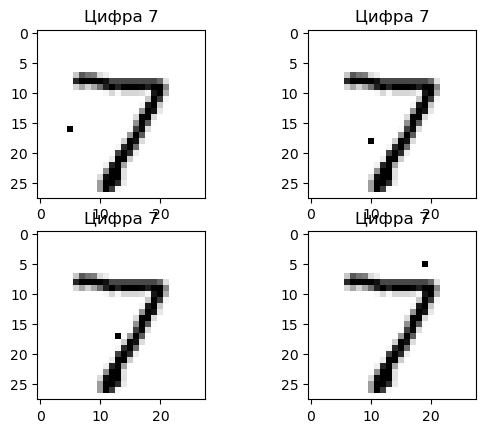

In [86]:
xs = [[16,  5, 255],
      [18, 10, 255],
      [17, 13, 255],
      [ 5, 19, 255]]
attacked_images = attack_image(xs, X_test[0])

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("Цифра %d" % y_test[0])
    plt.imshow(attacked_images[i].reshape(28, 28), cmap='Greys')

In [271]:
def predict_labels(images):
    # TODO: реализовать предсказание одной картинки
    dataset = TensorDataset(torch.from_numpy(np.array(images)).float(),
                            torch.from_numpy(np.array([-1]*len(images))).long()
                        )
    loader = DataLoader(dataset,
                          shuffle=True,
                          # pin_memory=True,
                          # num_workers=8,
                          drop_last=False,
                          batch_size=BATCH_SIZE)
    predictions = []
    for img, lbl in loader:
        out = model(img)
        predictions += torch.argmax(out, dim=1)
    return predictions

In [277]:
def evaluate_confidence(image, label):
    image = image.reshape(28, 28)
    vec = []
    for y in range(5, 23, 2):
        for x in range(5, 23, 2):
            value = 255 if image[y][x] < 128 else 0
            pix = [y, x, value]
            vec.append(pix)
    attacked_images = np.array(attack_image(vec, image))
    attacked_images = attacked_images.reshape(len(attacked_images), 1, 28, 28)
    predictions = predict_labels(attacked_images)
    # print(np.sum([pred == label for pred in predictions])/len(predictions)*100, '%')
    plt.figure(figsize=(20, 20))
    # for i in range(20):
    #     plt.subplot(4, 5, i+1)
    #     plt.title(predictions[i])
    #     plt.imshow(attacked_images[i].reshape(28, 28), cmap='Greys')
    return np.sum([pred == label for pred in predictions])/len(predictions)

In [309]:
print(evaluate_confidence(X_test[247], y_test[247]) * 100, '%')

39.50617283950617 %


In [278]:
from tqdm import tqdm

accuracies = []
for im in tqdm(range(10000)):
    accuracies.append(evaluate_confidence(X_test[im], y_test[im]))

100%|██████████| 10000/10000 [1:52:46<00:00,  1.48it/s]      


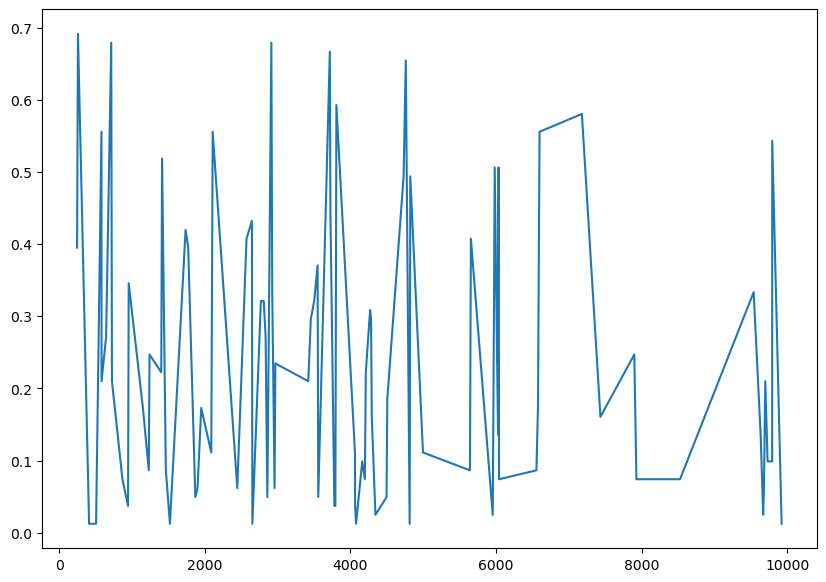

In [373]:
index = range(10000)
plt.figure(figsize=(10, 7))
plt.plot([i for i, a in enumerate(accuracies) if 0.7 > a > 0], [a for a in accuracies if 0.7 > a > 0])
plt.show()

In [305]:
print([i for i, a in enumerate(accuracies) if 0.7 > a > 0])

[247, 259, 412, 508, 582, 583, 646, 716, 726, 870, 947, 956, 1151, 1232, 1242, 1403, 1414, 1466, 1522, 1737, 1773, 1871, 1901, 1952, 2090, 2109, 2447, 2574, 2648, 2654, 2771, 2810, 2836, 2860, 2915, 2927, 2959, 2970, 3422, 3457, 3503, 3550, 3559, 3718, 3726, 3780, 3794, 3808, 4063, 4065, 4078, 4163, 4199, 4212, 4271, 4284, 4294, 4344, 4497, 4507, 4731, 4761, 4814, 4823, 4997, 5642, 5655, 5955, 5972, 5982, 6028, 6035, 6042, 6555, 6576, 6598, 7179, 7434, 7899, 7928, 8527, 9538, 9634, 9669, 9679, 9698, 9729, 9792, 9793, 9922]


In [279]:
attacked_images = evaluate_confidence(X_test[247], y_test[247])

In [306]:
len([i for i, a in enumerate(accuracies) if 0.7 > a > 0]) / len(accuracies)

0.009

Суммарный процент: 1.8099999999999998 %


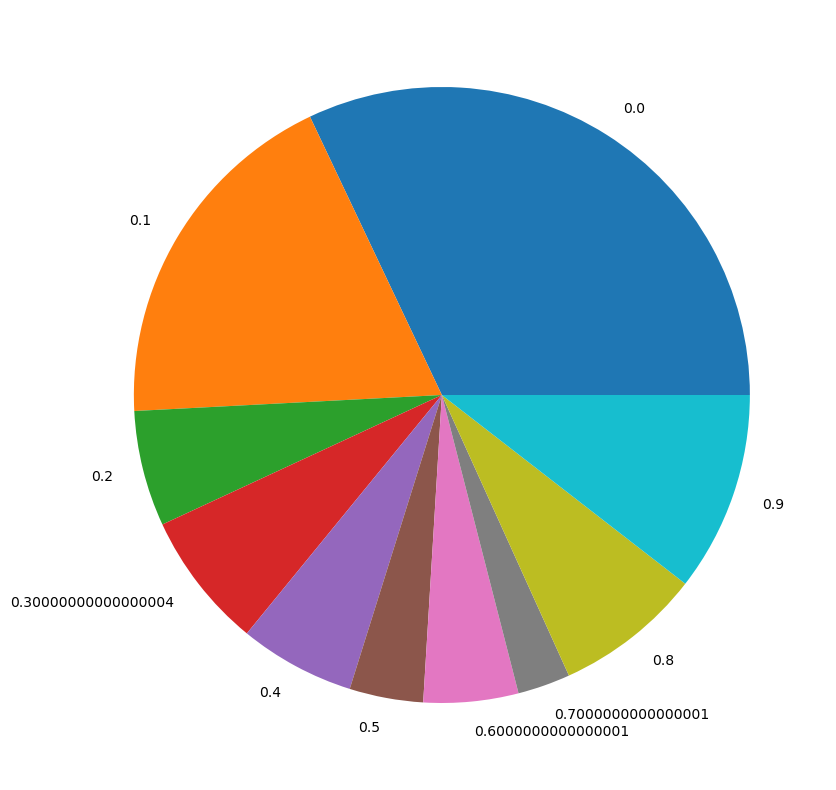

In [371]:
confidences = np.arange(0, 1, 0.1)
image_percentage = [len([a for a in accuracies if confidence-0.1 < a <= confidence]) / len(accuracies) for confidence in confidences]

print("Суммарный процент:", np.sum(image_percentage) * 100, '%')

plt.figure(figsize=(10, 10))
plt.pie(image_percentage, labels=confidences)
plt.show()